<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Автор: [Yury Kashnitsky](https://yorko.github.io). Все материалы распространяются под [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

# Задание #7
## Unsupervised learning - Обучение без учителя

В этой задаче мы рассмотрим, как работают методы снижения размерности данных и кластеризации. Одновременно мы еще раз попрактикуемся в решении задачи классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачать данные можно [здесь](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные получены с помощью акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее о характеристиках можно узнать по ссылке выше), также известен тип активности человека с телефоном в кармане - шел ли он, стоял, лежал, сидел, поднимался или спускался по лестнице.

Сначала представим, что тип активности нам неизвестен, и попробуем кластеризовать людей исключительно на основе имеющихся признаков. Затем мы решаем задачу определения типа физической активности как задачу классификации.

Ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1wBf5UoRndv6PpzIwYnM9f0ysoGa4Yqcqle-HBlBP5QQ/edit).

In [1]:
import os
from zipfile import ZipFile
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

%matplotlib inline
from matplotlib import pyplot as plt
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
filepath = "../data/UCI_HAR_Dataset.zip"
extractpath = filepath[:-4]
if not os.path.exists(filepath):
    print(f"Downloading dataset from \"{url}\"")
    response = requests.get(url)
    with open(filepath, 'wb') as f:
        f.write(response.content)
    print(f"Extracting dataset to \"{extractpath}\"")
    with ZipFile(filepath, 'r') as zipObj:
        zipObj.extractall(extractpath)

In [3]:
X_train = np.loadtxt(extractpath + "/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt(extractpath + "/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt(extractpath + "/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt(extractpath + "/UCI HAR Dataset/test/y_test.txt").astype(int)

In [4]:
# Checking dimensions
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен целевой вектор, поэтому мы будем работать с комбинацией обучающих и тестовых выборок. Объедините `X_train` с `X_test`, а `y_train` с `y_test`.

In [5]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

X.shape, y.shape

((10299, 561), (10299,))

Определить количество уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьба
- 2 - ходьба по лестнице
- 3 - ходить по лестнице
- 4 - сидеть
- 5 - стоять
- 6 - лежать

Масштабировать сэмпл с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Сократите число размерностей с помощью PCA, оставив столько компонент, сколько необходимо для объяснения не менее 90% дисперсии исходных (масштабированных) данных. Используйте масштабированный набор данных и исправьте `random_state` (константа RANDOM_STATE).

In [9]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

**Вопрос 1:**

Какое минимальное количество главных компонент необходимо для покрытия 90% дисперсии исходных (масштабированных) данных?

In [10]:
X_pca.shape

(10299, 65)

**Варианты ответа:**

- 56
- 65
- 66
- 193

Ответ: 65

**Вопрос 2:**

Какой процент дисперсии приходится на первую главную компоненту? Округлите до ближайшего процента.

**Варианты ответа:**

- 45
- 51
- 56
- 61

Ответ: 51

In [11]:
round(float(pca.explained_variance_ratio_[0] * 100))

51

Визуализация данных в проекции на первые две главные компоненты.

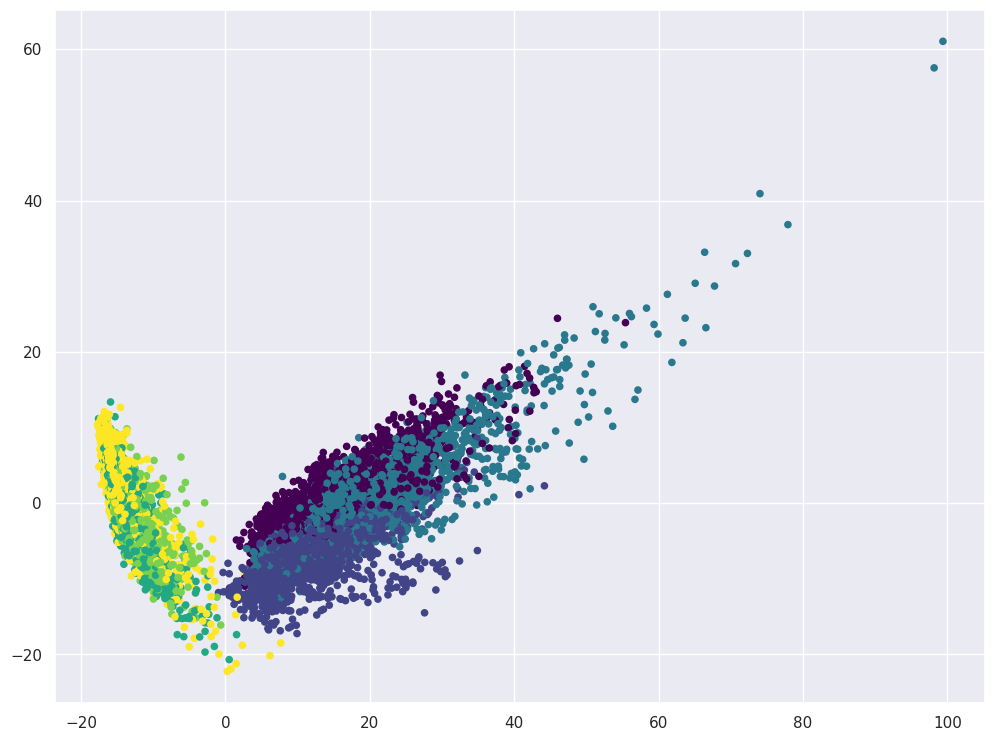

In [12]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');

**Вопрос 3:**

Если все получилось правильно, то вы увидите несколько кластеров, практически идеально отделенных друг от друга. Какие виды деятельности входят в эти кластеры?

**Варианты ответа:**

- 1 кластер: все 6 видов деятельности
- 2 кластера: (ходьба, ходьба по лестнице, ходьба по лестнице вниз) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (ходьба вверх, ходьба вниз) и (сидение, стояние, лежание)
- 6 кластеров

Ответ: 2 кластера

------------------------------

Выполнить кластеризацию методом `KMeans`, обучив модель на данных с пониженной размерностью (с помощью PCA). В данном случае мы дадим подсказку искать ровно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров нам следует искать.

Параметры:

- **n_clusters** = n_classes (количество уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата).

Остальные параметры должны иметь значения по умолчанию.

In [13]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными кластерами.

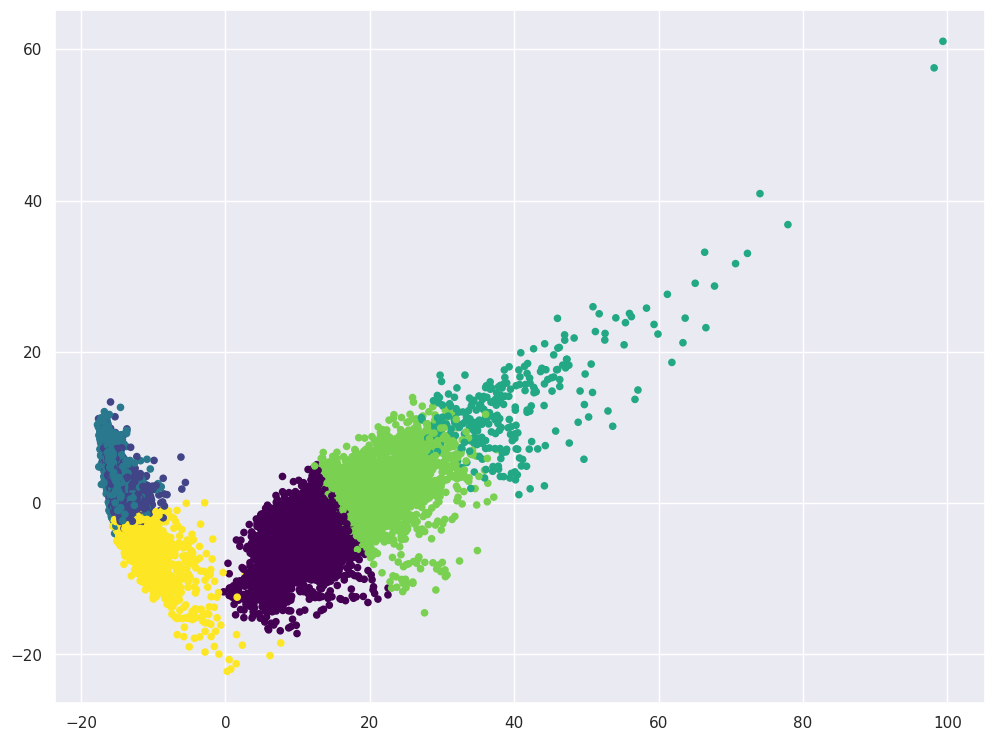

In [14]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды деятельности алгоритм `KMeans` путает.

In [15]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,903,0,0,78,741,0,1722
going up the stairs,1241,0,0,5,296,2,1544
going down the stairs,320,0,0,196,890,0,1406
sitting,1,1235,91,0,0,450,1777
standing,0,1344,0,0,0,562,1906
laying,5,52,1558,0,0,329,1944
all,2470,2631,1649,279,1927,1343,10299


Мы видим, что для каждого класса (т.е. для каждого вида деятельности) существует несколько кластеров. Рассмотрим максимальный процент объектов в классе, отнесенных к одному кластеру. Это будет простая метрика, характеризующая, насколько легко данный класс отделяется от других при кластеризации.

Пример: если для класса "хождение по лестнице" (к которому принадлежит 1406 экземпляров) распределение по кластерам следующее:
 - кластер 1 - 900
 - кластер 3 - 500
 - кластер 6 - 6,
 
то такая доля будет равна 900/1406 $ \approx $ 0,64.
 

**Вопрос 4:**

Какой вид деятельности отделяется от остальных лучше других на основе простой метрики, описанной выше?

**Варианты ответа:**

- ходьба
- стоя
- ходьба по лестнице
- все три варианта неверны

Ответ: все три варианта неверны

Видно, что kMeans не очень хорошо различает виды деятельности. Для выбора оптимального числа кластеров воспользуемся методом локтя. Параметры алгоритма и используемые данные те же, что и ранее, изменяем только `n_clusters`.

In [16]:
inertia = []
for k in tqdm(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

  0%|          | 0/6 [00:00<?, ?it/s]

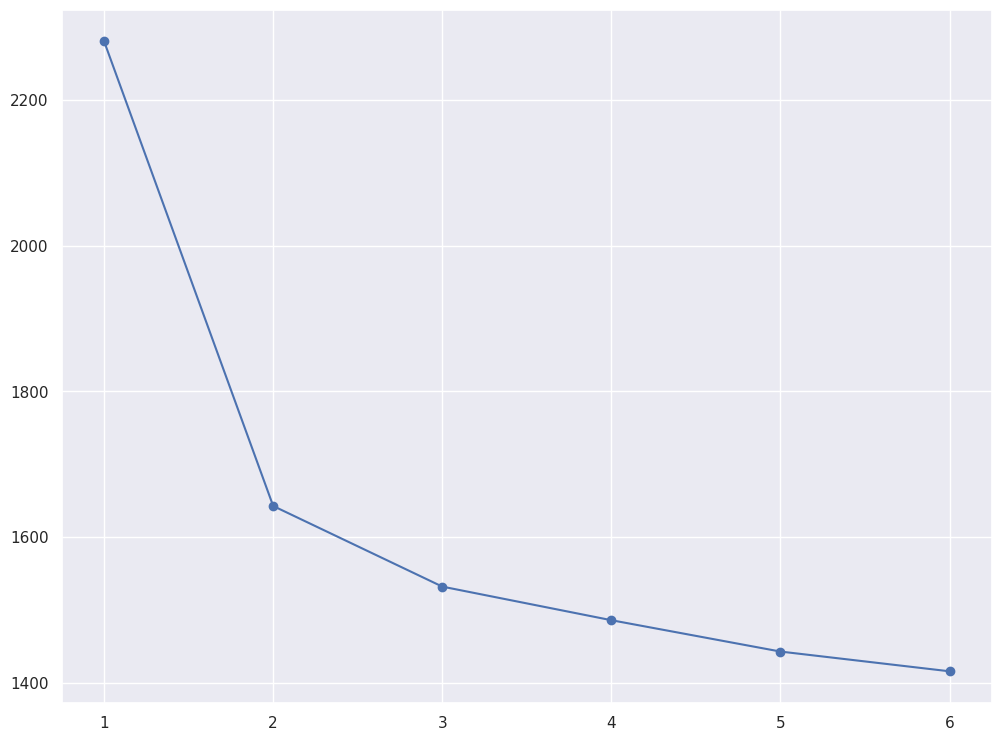

In [17]:
plt.plot(range(1, 7), inertia, marker="o");

[Выбор числа кластеров для kMeans](https://habr.com/ru/companies/ods/articles/325654/#vybor-chisla-klasterov-dlya-kmeans)

$$\large D(k)=\frac{| J(C_k) - J(C_{k+1}) |}{| J(C_{k-1}) - J(C_k) |} \rightarrow \underset{k}{\min}$$

In [18]:
d = {}

for k in range(2, 6):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

d

{2: 0.17344753560094123,
 3: 0.416885557558641,
 4: 0.9332195900967398,
 5: 0.6297019542007396}

**Вопрос 5:**

Сколько кластеров мы можем выбрать в соответствии с методом локтя?

**Варианты ответа:**

- 1
- 2
- 3
- 4

Ответ: 2

------------------------

Попробуем другой алгоритм кластеризации, описанный в статье - агломеративную кластеризацию.

In [19]:
ag = AgglomerativeClustering(
    n_clusters=n_classes, 
    linkage='ward'
).fit(X_pca)

Рассчитайте скорректированный индекс Рэнда (Adjusted Rand Index) (`sklearn.metrics`) для полученной кластеризации и для `KMeans` с параметрами из 4-го вопроса.

In [20]:
print(f"KMeans: {metrics.adjusted_rand_score(y, cluster_labels)}")
print(f"AgglomerativeClustering: {metrics.adjusted_rand_score(y, ag.labels_)}")

KMeans: 0.4198070012602345
AgglomerativeClustering: 0.49362763373004886


**Вопрос 6:**

Выберите все правильные утверждения.

**Варианты ответа:**

- Согласно ARI, KMeans справляется с кластеризацией хуже, чем агломеративная кластеризация 
- Для ARI не имеет значения, какие теги отнесены к кластеру, важно только разбиение экземпляров на кластеры 
- В случае случайного разбиения на кластеры ARI будет близок к нулю

**Ответы:**
- Да, чем выше ARI, тем лучше
- Да, если перенумеровать кластеры по-другому, ARI не изменится
- Да

-------------------------------

Можно заметить, что задача не очень хорошо решается, когда мы пытаемся обнаружить несколько кластеров (> 2). Теперь решим задачу классификации, учитывая, что данные помечены.

Для классификации используем support vector machine - класс `sklearn.svm.LinearSVC`. В данном курсе мы рассматривали этот алгоритм отдельно, но он хорошо известен, и о нем можно почитать, например, [здесь](http://cs231n.github.io/linear-classify/#svmvssoftmax).

Подбираем гиперпараметр `C` для `LinearSVC` с помощью `GridSearchCV`.

- Обучим новый `StandardScaler` на обучающем множестве (со всеми исходными признаками), применим масштабирование к тестовому множеству
- В `GridSearchCV` укажем `cv` = 3.

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [23]:
%%time

best_svc = GridSearchCV(svc, svc_params, cv=3, verbose=1, n_jobs=-1)
best_svc.fit(X_train_scaled, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Convergenc

CPU times: user 3.16 s, sys: 168 ms, total: 3.32 s
Wall time: 12.6 s


/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [24]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382506099134881)

**Вопрос 7**

Какое значение гиперпараметра `C` было выбрано наилучшим на основе кросс-валидации?

**Варианты ответа:**
- 0.001
- 0.01
- 0.1 
- 1
- 10

Ответ: 0.1

In [25]:
y_predicted = best_svc.predict(X_test_scaled)

In [26]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,laying,all
walking,494,2,0,0,0,0,496
climbing up the stairs,12,459,0,0,0,0,471
going down the stairs,2,3,414,1,0,0,420
sitting,0,4,0,426,61,0,491
standing,0,0,0,15,517,0,532
laying,0,0,0,0,11,526,537
all,508,468,414,442,589,526,2947


**Вопрос 8:**

Какой вид деятельности хуже всего определяется SVM с точки зрения precision? Recall?

**Варианты ответа:**

- precision - подниматься по лестнице, recall - лежать
- precision - лежать, recall - сидеть
- precision - ходьба, recall - ходьба
- precision - стоять, recall - сидеть

Ответ: precision - стоять, recall - сидеть

Наконец, выполните то же самое, что и в вопросе 7, но добавьте PCA.

- Используйте `X_train_scaled` и `X_test_scaled`
- Обучить PCA, как и ранее, на масштабированном обучающем множестве, применить масштабирование к тестовому множеству
- Выбрать гиперпараметр `C` путем кросс-валидации на обучающем множестве с PCA-преобразованием. Вы заметите, насколько быстрее это работает

**Вопрос 9:**

Какова разница между наилучшим качеством (accuracy) для кросс-валидации в случае всех 561 исходных характеристик и во втором случае, когда был применен метод главных компонент? Округлите до ближайшего процента.

**Варианты ответа:**
- качество одинаковое
- 2%
- 4%
- 10%
- 20%

Ответ: 4%

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [28]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [29]:
%%time

best_svc_pca = GridSearchCV(svc, svc_params, cv=3, verbose=1, n_jobs=-1)
best_svc_pca.fit(X_train_pca, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Convergenc

CPU times: user 814 ms, sys: 228 ms, total: 1.04 s
Wall time: 2.59 s


/home/m-melgizin/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [30]:
best_svc_pca.best_params_, best_svc_pca.best_score_

({'C': 1}, 0.8998943094169531)

In [31]:
round(100 * (best_svc_pca.best_score_ - best_svc.best_score_))

-4

**Вопрос 10:**

Выберите все правильные утверждения:

**Варианты ответов:**

- Анализ главных компонент в данном случае позволил сократить время обучения модели, но качество (средняя точность кросс-валидации) сильно пострадало - более чем на 10%.
- PCA может использоваться для визуализации данных, однако для этой задачи существуют более эффективные методы, например, tSNE. Однако PCA обладает меньшей вычислительной сложностью 
- PCA строит линейные комбинации исходных признаков, и в некоторых приложениях они могут быть плохо интерпретированы человеком

**Ответ:**

- Первое утверждение верно, анализ главных компонент в данном случае позволил существенно сократить время обучения модели, но качество пострадало не так сильно - всего на 4%
- Для визуализации многомерных данных лучше использовать методы многомерного обучения, в частности, tSNE. При этом метрики, оценивающие качество визуализации, пока не придуманы, но tSNE широко используется именно потому, что в некоторых случаях строит "хорошие" картинки, отображающие структуру данных, как в случае с MNIST
- Линейные комбинации признаков, которые строит PCA, часто плохо интерпретируются человеком, например, 0,574 * salary + 0,234 * num_children